# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.0 MB/s eta 0:00:00
  Created wheel for karateclub: filename=karateclub-1.3.3-py3-none-any.whl size=102005 sha256=f1874a7e6fb28b663dd0125f5e23a1c5933e7ee9df294a9a3fae80677111e16f
  Stored in directory: /root/.cache/pip/wheels/62/bd/af/17e7ca6ba0ed144d22502780f5c0660a8e4985939dc6973a81
Successfully built karateclub
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Un

Accuracy basic features: 0.87

ROC AUC basic features: 0.87



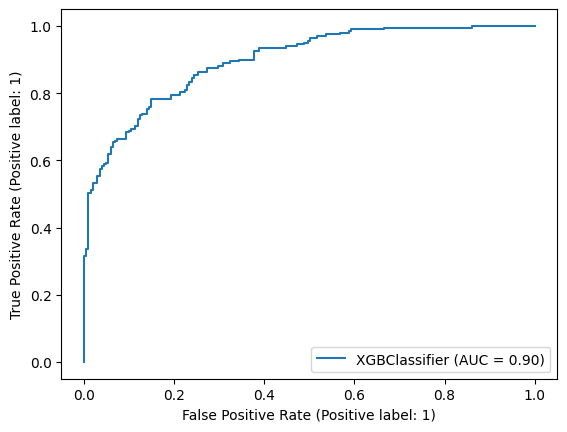

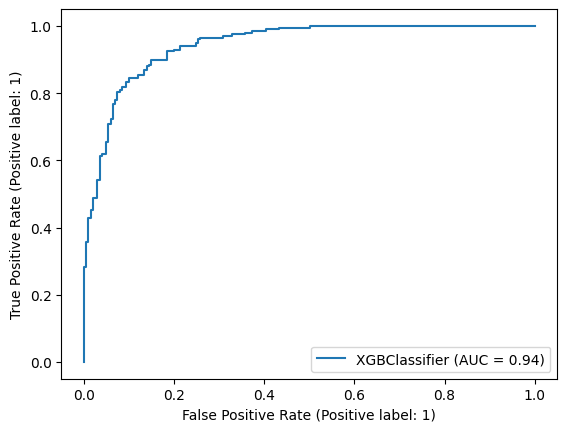

In [1]:
# Data https://neurodata.io/project/connectomes/#:~:text=Mixed.species_brain_1

!pip install karateclub

import os
import re
import random
import operator
import numpy as np
import pandas as pd
import networkx as nx
import xgboost as xgb
import karateclub
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from functools import lru_cache

def common_friends(g, u, v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

@lru_cache
def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set

def rank_friends_of_friends(g, v):
    rank_dict = {}
    vertices_set = find_friends_of_friends(g, v)
    for u in vertices_set:
        rank_dict[u] = len(common_friends(g, v, u))
    sorted_d = sorted(rank_dict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_d

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)

def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g, u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'from': u,
            'to': v,
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'friends_measure': friends_measure(g, u,v)
        }
    except Exception as e: 
        print(e)
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

def links_features_extraction(postive_links, negative_links):
  links_features = []
  for i in range(len(postive_links)):    
      u,v = postive_links[i]
      d = get_features_dict(g, u,v )
      if d is None:
          continue
      d['class'] = True
      links_features.append(d)

  for i in range(len(negative_links)):    
      u,v = negative_links[i]
      d = get_features_dict(g, u,v )
      if d is None:
          continue
      d['class'] = False
      links_features.append(d)
  
  return links_features

# Read data
g = nx.read_graphml("mixed.species_brain_1.graphml")
# Get positive links
postive_links = select_random_existing_links(g, 1000)
# Get negative links
negative_links = select_random_non_existing_links(g, 1000)
# Get links featurs
links_features = links_features_extraction(postive_links, negative_links)
# Create dataframe 
df = pd.DataFrame(links_features)
df["class"] = df["class"].astype(int)
# Create train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
y_train, y_test = train['class'], test['class']
X_train = train.drop(['class', 'from', 'to'], axis=1)
X_test = test.drop(['class', 'from', 'to'], axis=1)
# Train a model
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
# Get predictions
y_predict = xgb_classifier.predict(X_test)
# Eval model
print(f"Accuracy basic features: {round(accuracy_score(y_test, y_predict), 3)}", end="\n\n")
print(f"ROC AUC basic features: {round(roc_auc_score(y_test, y_predict), 3)}", end="\n\n")
ax = RocCurveDisplay.from_estimator(xgb_classifier, X_test, y_test)
# Get nodes and numbers
l =  zip(g.nodes(), range(len(g.nodes())))
l = list(l)
nodes_dict = dict(l)
# Create graph of numbers instead of string
h = nx.DiGraph()
for e1,e2 in g.edges():
  h.add_edge(nodes_dict[e1], nodes_dict[e2])
# Get node embeddings
model = karateclub.DeepWalk()
model.fit(h)
embedding = model.get_embedding()
# Combine node embeddings
train_embeddings_features = np.array([np.concatenate([embedding[nodes_dict[from_name]], embedding[nodes_dict[to_name]]]) for from_name, to_name in list(zip(train['from'], train['to']))])
train_embeddings_features_df = pd.DataFrame(train_embeddings_features, columns=[f'embed_{i}' for i in range(train_embeddings_features.shape[1])])
train_embeddings_features_df.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)
train_stacked_test_df = pd.concat([train, train_embeddings_features_df], axis=1)
test_embeddings_features = np.array([np.concatenate([embedding[nodes_dict[from_name]], embedding[nodes_dict[to_name]]]) for from_name, to_name in list(zip(test['from'], test['to']))])
test_embeddings_features_df = pd.DataFrame(test_embeddings_features, columns=[f'embed_{i}' for i in range(test_embeddings_features.shape[1])])
test_embeddings_features_df.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test_stacked_test_df = pd.concat([test, test_embeddings_features_df], axis=1)
# Create train and test sets
y_train, y_test = train_stacked_test_df['class'], test_stacked_test_df['class']
X_train = train_stacked_test_df.drop(['class', 'from', 'to'], axis=1)
X_test = test_stacked_test_df.drop(['class', 'from', 'to'], axis=1)
# Train a model
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
# Get predictions
y_predict = xgb_classifier.predict(X_test)
# Eval model
print(f"Accuracy basic features: {round(accuracy_score(y_test, y_predict), 3)}", end="\n\n")
print(f"ROC AUC basic features: {round(roc_auc_score(y_test, y_predict), 3)}", end="\n\n")
ax = RocCurveDisplay.from_estimator(xgb_classifier, X_test, y_test)

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/282.
maildir/campbell-l/all_documents/1572.
maildir/campbell-l/all_documents/759.
maildir/campbell-l/all_documents/538.
maildir/campbell-l/all_documents/876.
maildir/campbell-l/all_documents/321.
maildir/campbell-l/all_documents/990.
maildir/campbell-l/all_documents/1842.
maildir/campbell-l/all_documents/1460.
maildir/campbell-l/all_documents/1840.
maildir/campbell-l/all_documents/274.
maildir/campbell-l/all_documents/448.
maildir/campbell-l/all_documents/1692.
maildir/campbell-l/all_documents/400.
maildir/campbell-l/all_documents/224.
maildir/campbell-l/all_documents/188.
maildir/campbell-l/all_documents/1670.
maildir/campbell-l/all_documents/1678.
maildir/campbell-l/all_documents/706.
maildir/campbell-l/all_documents/254.
maildir/campbell-l/all_documents/1429.
maildir/campbell-l/all_documents/1704.
maildir/campbell-l/all_documents/529.
maildir/campbell-l/all_documents/1039.
maildir/campbell-l/all_docu

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


degree_centrality precision@10: 0.3
eigenvector_centrality precision@10: 0.7
closeness_centrality precision@10: 0.8


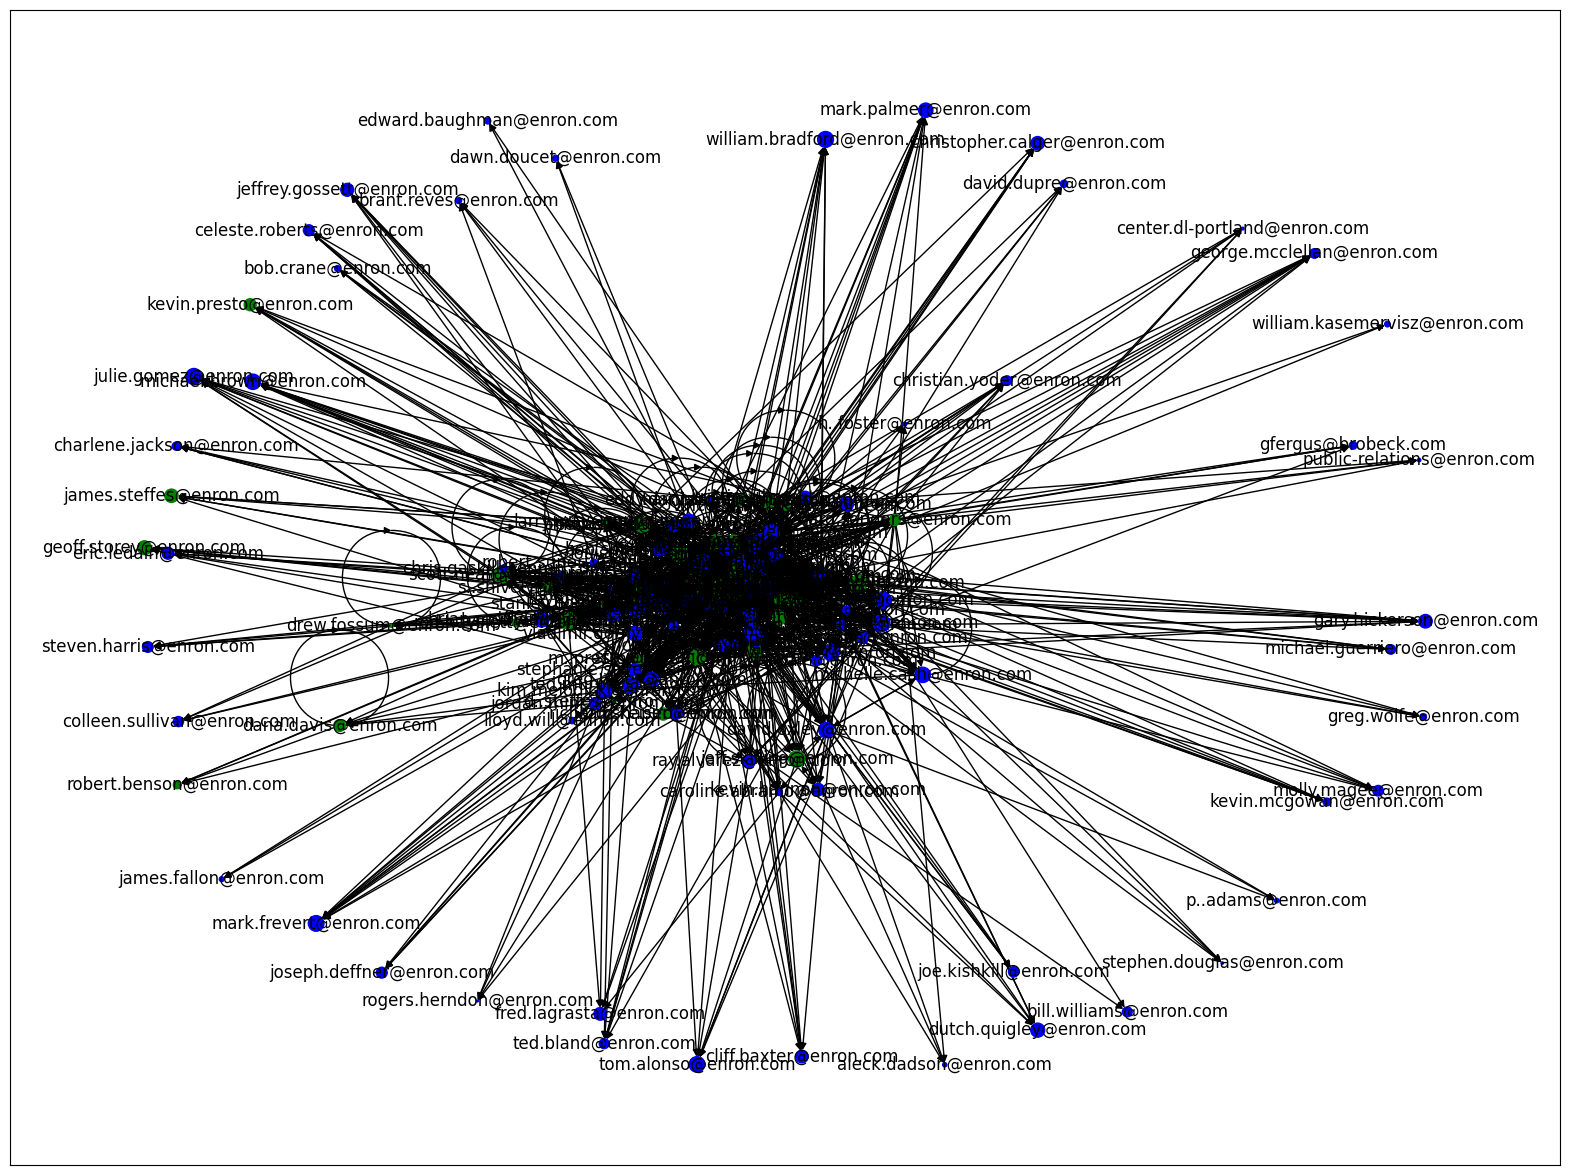

In [2]:
!wget -O enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
!tar -zxvf enron_mail_20150507.tar.gz

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"./maildir/*/*/*") if "/inbox/" in p or "/sent/" in p]
for i in range(len(files_list)):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

# Create graph
g = nx.DiGraph()
g.add_edges_from(links)

# Get degree centrality
degree_centrality_d = nx.degree_centrality(g)
sorted_degree_centrality_d = sorted(degree_centrality_d.items(), key=lambda item: item[1], reverse=True)
sorted_degree_centrality_d

# Get eigenvector centrality
eigenvector_centrality_d = nx.eigenvector_centrality(g)
sorted_eigenvector_centrality_d = sorted(eigenvector_centrality_d.items(), key=lambda item: item[1], reverse=True)
sorted_eigenvector_centrality_d

# Get closeness centrality
closeness_centrality_d = nx.closeness_centrality(g)
sorted_closeness_centrality_d = sorted(closeness_centrality_d.items(), key=lambda item: item[1], reverse=True)
sorted_closeness_centrality_d

# Create dataframe for all people
df = pd.DataFrame(g.nodes(), columns=['node_email'])
df['node_name'] = df.node_email.apply(lambda node_email: node_email.split('@')[0])

# Get roles
roles_path = "http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt"
role_df = pd.read_csv(roles_path, sep="	", header=None, error_bad_lines=False, names=['name', 'role'])

# Merges dataframe of all people and roles
merged_df = df.merge(role_df,how='left',left_on=['node_name'],right_on=['name'])

# Get managers
consider_manager = ['Vice President', 'President', 'Manager' , 'Managing Director', 'Director', 'CEO']
merged_df['managers'] = merged_df.role.apply(lambda role: (role is not np.nan) and any([manager_role in role for manager_role in consider_manager]))

# Evaluate the precision@10 of the algorithms
for i,j in zip(["degree_centrality", "eigenvector_centrality", "closeness_centrality"], [sorted_degree_centrality_d, sorted_eigenvector_centrality_d, sorted_closeness_centrality_d]):
    count = merged_df[merged_df.node_email.isin([d[0] for d in j[:10]])].managers.sum()
    print(f"{i} precision@10: {count/10}")

# Draw the network and visualize one of the centrality measures
nodelist = [d[0] for d in sorted_closeness_centrality_d[:150]]
node_size = [len(nodelist)-idx for idx, d in enumerate(sorted_closeness_centrality_d[:150])]
node_color = ['green' if merged_df[merged_df.node_email == node_email].managers.item() else 'blue' for node_email in nodelist]
h = g.subgraph(nodelist)
plt.figure(figsize=(20,15))
nx.draw_networkx(h, with_labels=True, nodelist=nodelist, node_size=node_size, node_color=node_color)